# Preprocessing

In [1]:

docs = [
    "flying fish flew by the space station",
    "the fish was caught by the fisherman",
    "soaring fish soared past the orbital station",
    "cooked fish was in the space",
]

s1 = "flying fish flew by the space station"
s2 = "fly me the moon, let me play among the stars"

In [2]:
import numpy as np

def formatting(x):
    if isinstance(x, set):
        x = list(x)
    if not isinstance(x[0], str):
        x = list(map(str, x))
    return ", ".join(x[:3] + ["..."] + x[-3:])

def shingling(s: str, k: int):
    s = "_" + s
    s = s.replace(" ", "_")

    shingles = set()
    for i in range(len(s) - k + 1):
        shingles.add(s[i:i+k])
    return shingles

def jaccard(x: set, y: set):
    shared = x.intersection(y)
    union = x.union(y)
    return len(shared) / len(union)

k = 3
# s1_shingles = shingling(s1, k)
# s2_shingles = shingling(s2, k)
# print("s1 = {" + formatting(s1_shingles) + "}")
# print("s2 = {" + formatting(s2_shingles) + "}")
    
docs_shingling = [shingling(s, k) for s in docs]
for i, shingles in enumerate(docs_shingling):
    print("doc{} = {{{}}}".format(i+1, formatting(shingles)))

# matrix jaccard similarity
    
def get_docs_similarity(docs_set: list[set]):
    if not isinstance(docs_set[0], set):
        docs_set = [set(x) for x in docs_set]

    n_docs = len(docs_set)
    docs_similarity = np.zeros((n_docs, n_docs)) 
    for i in range(n_docs):
        for j in range(i+1, n_docs):
            docs_similarity[i, j] = jaccard(docs_set[i], docs_set[j])
            docs_similarity[j, i] = docs_similarity[i, j]
    return docs_similarity

docs_similarity = get_docs_similarity(docs_shingling)

print("Jaccard similarity matrix:")
print(docs_similarity.round(4))

doc1 = {by_, ing, fis, ..., h_f, ew_, sh_}
doc2 = {by_, s_c, fis, ..., her, sh_, h_w}
doc3 = {ing, fis, are, ..., d_p, rbi, sh_}
doc4 = {ked, fis, e_s, ..., ace, sh_, h_w}
Jaccard similarity matrix:
[[0.     0.1923 0.2759 0.2449]
 [0.1923 0.     0.1148 0.25  ]
 [0.2759 0.1148 0.     0.1356]
 [0.2449 0.25   0.1356 0.    ]]


In [3]:
# vocabulary = list(s1_shingles.union(s2_shingles))
vocabulary = list(set().union(*docs_shingling))

In [4]:
def one_hot_encode(shingles: set, vocabulary: list[str]):
    vector = [1 if token in shingles else 0 for token in vocabulary]
    return vector

docs_vectors = np.array([one_hot_encode(shingles, vocabulary) for shingles in docs_shingling])
# s1_vector = one_hot_encode(s1_shingles, vocabulary)
# s2_vector = one_hot_encode(s2_shingles, vocabulary)
# print("s1 = [" + formatting(s1_vector) + "]")
# print("s2 = [" + formatting(s2_vector) + "]")
print("The shape of doc vectors =", docs_vectors.shape)

The shape of doc vectors = (4, 86)


In [5]:
def create_hashes(N: int, V: int) -> np.ndarray:
    hashes = np.zeros((N, V), dtype=int)
    for i in range(N):
        permutation = np.random.permutation(V) + 1
        hashes[i, :] = permutation.copy()
    return hashes  # N x V

np.random.seed(0)
N = 20
hashes = create_hashes(N, V=len(vocabulary))
hashes.shape

(20, 86)

In [6]:
# pure python create signature
from tqdm.notebook import tqdm

def create_signature(
        vector: np.ndarray, 
        hashses: np.ndarray, 
        vocabulary: list[str],
        verbose: bool = False
    ):
    signature = []
    iterator = tqdm(enumerate(hashses))
    for k, func in iterator:
        for i in range(1, len(vocabulary)+1):
            idx = list(func).index(i)  # search hash value index in hash map
            signature_val = vector[idx]
            if verbose:
                print(f"{i} -> {idx} -> {signature_val}")
            if signature_val == 1:
                signature.append(idx)
                if verbose:
                    print('match!')
                break
    return signature

def create_signatures_plain(hashes: np.ndarray, docs_vectors: np.ndarray) -> np.ndarray:
    signatures = []
    for vector in docs_vectors:
        signature = create_signature(vector, hashes, vocabulary)
        signatures.append(signature)
    return np.array(signatures)

# numpy create signature
def create_signatures(hashes, docs_vectors):
    argsorted_hashes_index = np.argsort(hashes) # N x V
    check_is_one = docs_vectors[:, argsorted_hashes_index]  # num_docs x N x V
    first_nonzero_idx = np.argmax(check_is_one, axis=2, keepdims=True)  # num_docs x N x 1
    signatures = np.take_along_axis(
        np.tile(argsorted_hashes_index, (len(docs_vectors), 1, 1)), 
        first_nonzero_idx, axis=2
        ).squeeze(-1)  # num_docs x N
    signatures
    return signatures

signatures_plain = create_signatures_plain(hashes, docs_vectors)
signatures = create_signatures(hashes, docs_vectors)

print(signatures_plain)
print(signatures)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[[47 84 20 78 47 80 73 37 63 24 80 31 37 36 56 31 24 78 55 20]
 [44 79 19 45 17 45 59 37 44 59 32 72 37 27 60 49 37 13 45  9]
 [47 57 53  8 47 30 57 37 61  8 62 34 66 12 56 49 24 21 83 53]
 [ 0 68 68 52 25 81 40 37 37 64 25 52 25 15 56 49 37 52 35 15]]
[[47 84 20 78 47 80 73 37 63 24 80 31 37 36 56 31 24 78 55 20]
 [44 79 19 45 17 45 59 37 44 59 32 72 37 27 60 49 37 13 45  9]
 [47 57 53  8 47 30 57 37 61  8 62 34 66 12 56 49 24 21 83 53]
 [ 0 68 68 52 25 81 40 37 37 64 25 52 25 15 56 49 37 52 35 15]]


50


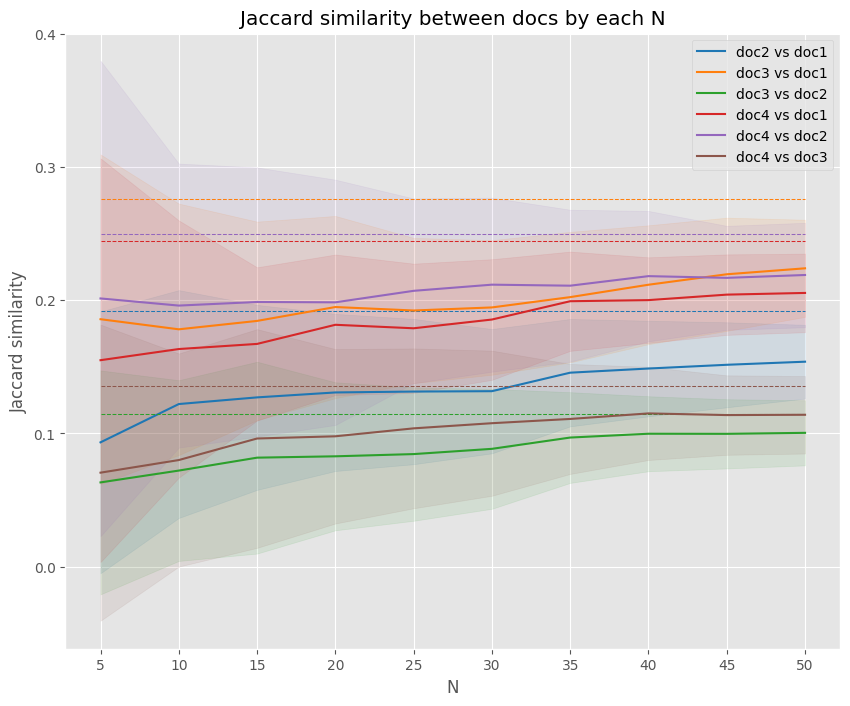

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def run_exp(n_exp, candidates_of_N, vocab_length, docs_vectors, rows, cols):
    max_N = candidates_of_N[-1]
    print(max_N)
    exp_res = []  # n_exp x len(candidates_of_N) x len(combination of (rows and cols))
    for _ in range(n_exp):
        hashes = create_hashes(max_N, V=vocab_length)
        current_exp = []
        for N in candidates_of_N:
            # create signatures
            signatures = create_signatures(hashes[:N], docs_vectors)
            docs_similarity_lsh = get_docs_similarity(signatures)
            current_exp.append(docs_similarity_lsh[rows, cols])
        exp_res.append(np.array(current_exp))
    exp_res = np.array(exp_res)

    mean_exp_res = np.mean(exp_res, axis=0)
    std_exp_res = np.std(exp_res, axis=0)
    return mean_exp_res, std_exp_res

def draw(rows, cols, candidates_of_N, mean_exp_res, std_exp_res, docs_similarity):
    palette = sns.color_palette("tab10", len(rows)).as_hex()
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    for i_rc, (row, col) in enumerate(zip(rows, cols)):
        sns.lineplot(x=candidates_of_N, y=mean_exp_res[:, i_rc], c=palette[i_rc], 
                    linewidth=1.5, label=f"doc{row+1} vs doc{col+1}", ax=ax)
        ax.fill_between(candidates_of_N, mean_exp_res[:, i_rc]-std_exp_res[:, i_rc], mean_exp_res[:, i_rc]+std_exp_res[:, i_rc], 
                        color=palette[i_rc], alpha=0.1)

        y = [docs_similarity[row, col]]*len(candidates_of_N)
        ax.plot(candidates_of_N, y, color=palette[i_rc], linewidth=0.75, linestyle='--')

    ax.set_xticks(candidates_of_N)
    ax.set_xticklabels(candidates_of_N)
    ax.set_title("Jaccard similarity between docs by each N")
    ax.set_xlabel("N")
    ax.set_ylabel("Jaccard similarity")
    ax.legend()
    plt.show()


def main(docs_shingling, docs_vectors, vocabulary, n_exp=30, interval=5):
    candidates_of_N = np.arange(interval, 50+interval, interval)
    docs_similarity = get_docs_similarity(docs_shingling)
    rows, cols = np.tril_indices(docs_similarity.shape[0], k=-1)  # lower triangle index
    vocab_length = len(vocabulary)
    mean_exp_res, std_exp_res = run_exp(
        n_exp, candidates_of_N, vocab_length, docs_vectors, rows, cols
    )
    draw(rows, cols, candidates_of_N, mean_exp_res, std_exp_res, docs_similarity)

main(docs_shingling, docs_vectors, vocabulary, n_exp=30, interval=5)

In [8]:
signatures.shape

(4, 20)

information transfer

In [9]:
print(f'Jaccard Index for doc1 vs doc2:')
print(f'Shinlings: {jaccard(docs_shingling[0], docs_shingling[1]):.4f}')
print(f'Signatures: {jaccard(set(signatures[0]), set(signatures[1])):.4f}')

print(f'Jaccard Index for doc1 vs doc3:')
print(f'Shinlings: {jaccard(docs_shingling[0], docs_shingling[2]):.4f}')
print(f'Signatures: {jaccard(set(signatures[0]), set(signatures[2])):.4f}')

print(f'Jaccard Index for doc2 vs doc3:')
print(f'Shinlings: {jaccard(docs_shingling[1], docs_shingling[2]):.4f}')
print(f'Signatures: {jaccard(set(signatures[1]), set(signatures[2])):.4f}')

print(f'Jaccard Index for doc1 vs doc4:')
print(f'Shinlings: {jaccard(docs_shingling[0], docs_shingling[3]):.4f}')
print(f'Signatures: {jaccard(set(signatures[0]), set(signatures[3])):.4f}')

Jaccard Index for doc1 vs doc2:
Shinlings: 0.1923
Signatures: 0.0385
Jaccard Index for doc1 vs doc3:
Shinlings: 0.2759
Signatures: 0.1600
Jaccard Index for doc2 vs doc3:
Shinlings: 0.1148
Signatures: 0.0714
Jaccard Index for doc1 vs doc4:
Shinlings: 0.2449
Signatures: 0.0870


band and hash

In [10]:
signatures.shape

(4, 20)

In [11]:
def get_bands(signatures, r):
    _, n_hashes = signatures.shape
    assert n_hashes % r == 0
    b = n_hashes // r  # number of bands
    bands = np.array(np.split(signatures, b, axis=1))
    return np.transpose(bands, (1, 0, 2))

r = 2 # length of each sub-vector(signature)
b = len(signatures[0]) // r # number of bands

bands = get_bands(signatures, r)
n_docs = len(bands)
similar_docs = np.zeros((n_docs, n_docs), dtype=int)
for i in range(n_docs):  # row
    for j in range(n_docs):  # column
        if i == j:
            similar_docs[i,j] = 0
            continue
        n_equal = (np.equal(bands[i], bands[j]).sum(1) == r).sum()
        if n_equal > 0:
            similar_docs[i,j] = n_equal

print("Similarity matrix:")
print(similar_docs)

Similarity matrix:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [12]:
from itertools import combinations

class LSH:
    def __init__(self, b):
        self.b = b  # number of bands
        self.buckets = [{} for _ in range(self.b)]
        self.counter = 0

    def get_bands(self, signatures):
        self.n_docs, self.n_sig = signatures.shape
        assert self.n_sig % self.b == 0, f"band size(={self.b}) should have 0 remainder. shape of signatures (n_docs, n_sig)= {signatures.shape}"
        self.r = self.n_sig // self.b  # length of each sub-vector(signature)

        bands = np.array(np.split(signatures, self.b, axis=1))
        return np.transpose(bands, (1, 0, 2))

    def create_hashes(self, signatures):
        bands = self.get_bands(signatures)
        n_docs = len(bands)
        for k in range(n_docs):
            for i, subvec in enumerate(bands[k]):
                subvec = tuple(subvec)
                if subvec not in self.buckets[i]:
                    self.buckets[i][subvec] = set()
                self.buckets[i][subvec].add(self.counter)
            self.counter += 1

    def get_candidates(self):
        candidates = []
        for bucket_band in self.buckets:
            keys = bucket_band.keys()
            for bucket in keys:
                hits = bucket_band[bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

In [13]:
lsh = LSH(b=10)
lsh.create_hashes(signatures)
candidates = lsh.get_candidates()
print("Candidates =", candidates)
print(f"r = {lsh.r}, b = {lsh.b}")

Candidates = {(2, 3)}
r = 2, b = 10


In [14]:
lsh.buckets

[{(47, 84): {0}, (44, 79): {1}, (47, 57): {2}, (0, 68): {3}},
 {(20, 78): {0}, (19, 45): {1}, (53, 8): {2}, (68, 52): {3}},
 {(47, 80): {0}, (17, 45): {1}, (47, 30): {2}, (25, 81): {3}},
 {(73, 37): {0}, (59, 37): {1}, (57, 37): {2}, (40, 37): {3}},
 {(63, 24): {0}, (44, 59): {1}, (61, 8): {2}, (37, 64): {3}},
 {(80, 31): {0}, (32, 72): {1}, (62, 34): {2}, (25, 52): {3}},
 {(37, 36): {0}, (37, 27): {1}, (66, 12): {2}, (25, 15): {3}},
 {(56, 31): {0}, (60, 49): {1}, (56, 49): {2, 3}},
 {(24, 78): {0}, (37, 13): {1}, (24, 21): {2}, (37, 52): {3}},
 {(55, 20): {0}, (45, 9): {1}, (83, 53): {2}, (35, 15): {3}}]

In [15]:
import requests
import pandas as pd
import io

url = "https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt"

text = requests.get(url).text

data = pd.read_csv(io.StringIO(text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [16]:
def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

In [77]:
# apply shingles
k = 8
docsA = [shingling(s, k) for s in data["sentence_A"].str.lower().sample(500)]

# get vocabulary
vocabulary = build_vocab(docsA)

# one-hot encoding
docsA_vectors = np.array([one_hot_encode(shingles, vocabulary) for shingles in docsA])

# create signatures
N = 100
hashes = create_hashes(N, V=len(vocabulary))
signatures = create_signatures(hashes, docsA_vectors)

In [78]:
b = 20
lsh = LSH(b=b)
lsh.create_hashes(signatures)
candidate_pairs = lsh.get_candidates()
len(candidate_pairs)
list(candidate_pairs)[:5]

[(499, 238), (475, 491), (259, 150), (368, 389), (488, 366)]

In [79]:
from sklearn.metrics.pairwise import cosine_similarity

def get_pairs(docsA, signatures, candidate_pairs, sample_size = 50000):
    pairs = []

    data_len = len(docsA)
    chosen = set()
    # take random sample of pairs
    for _ in tqdm(range(sample_size)):
        x, y = np.random.choice(data_len, 2)
        if x == y or (x, y) in chosen: continue
        chosen.add((x, y))
        vector_x = signatures[x]
        vector_y = signatures[y]
        candidate = 1 if ((x, y) in candidate_pairs) else 0
        cosine = cosine_similarity([vector_x], [vector_y])[0][0]
        pairs.append({
                'x': x,
                'y': y,
                'jaccard': jaccard(set(vector_x), set(vector_y)),
                'cosine': cosine,
                'candidate': candidate
            })

    pairs = pd.DataFrame(pairs)
    # add a normalized cosine column for better alignment
    cos_min = pairs['cosine'].min()
    cos_max = pairs['cosine'].max()
    pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

    return pairs

pairs = get_pairs(docsA, signatures, candidate_pairs)

  0%|          | 0/50000 [00:00<?, ?it/s]

<Axes: xlabel='cosine', ylabel='candidate'>

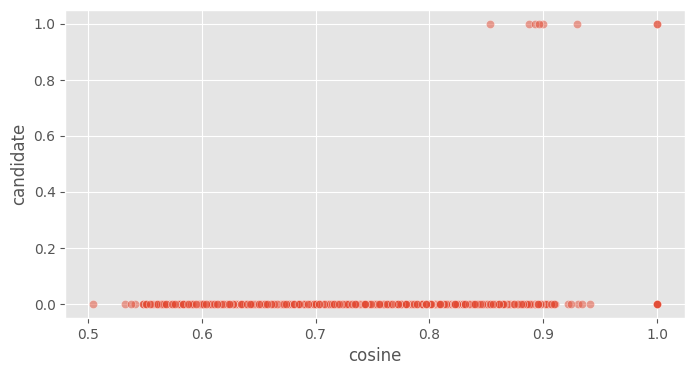

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.5, ax=ax)

<Axes: xlabel='cosine', ylabel='candidate'>

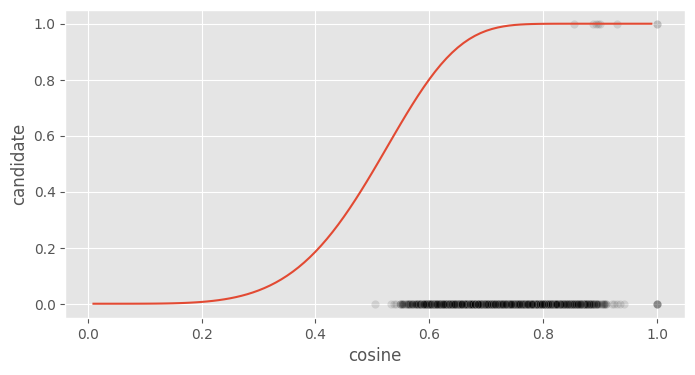

In [81]:
def probability(s, r, b):
    # s: similarity threshold
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

r = int(N / b)
thresholds = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in thresholds]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(x=thresholds, y=P_scores, ax=ax)
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.1, color='k', ax=ax)

<Axes: xlabel='cosine_norm', ylabel='candidate'>

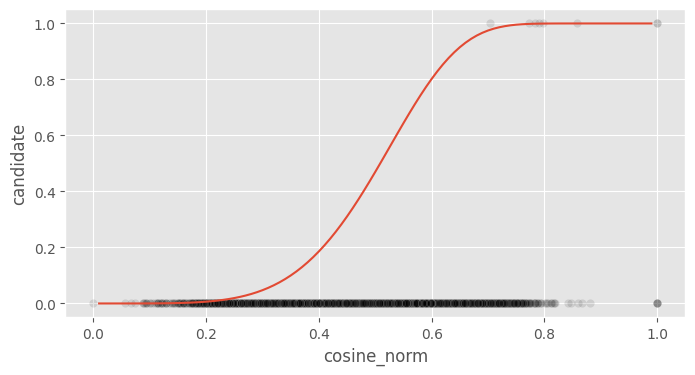

In [82]:
thresholds = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in thresholds]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(x=thresholds, y=P_scores, ax=ax)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.1, color='k', ax=ax)

In [83]:
b2 = 25
lsh2 = LSH(b=b2)
lsh2.create_hashes(signatures)
candidate_pairs2 = lsh2.get_candidates()
len(candidate_pairs2)
list(candidate_pairs2)[:5]

pairs2 = get_pairs(docsA, signatures, candidate_pairs2)

  0%|          | 0/50000 [00:00<?, ?it/s]

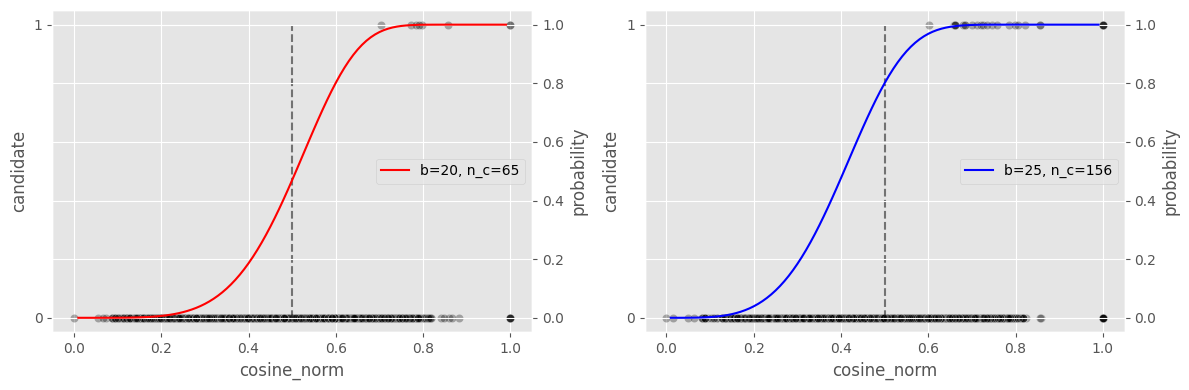

In [133]:
thresholds = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, lsh.r, lsh.b) for s in thresholds]
P_scores2 = [probability(s, lsh2.r, lsh2.b) for s in thresholds]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
ax1, ax2 = axes
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax22.sharey(ax11)

sns.lineplot(x=thresholds, y=P_scores, label=f'b={lsh.b}, n_c={len(candidate_pairs)}', color='r', ax=ax11)
sns.lineplot(x=thresholds, y=P_scores2, label=f'b={lsh2.b}, n_c={len(candidate_pairs2)}', color='b', ax=ax22)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.3, color='k', ax=ax1)
sns.scatterplot(data=pairs2, x='cosine_norm', y='candidate', alpha=0.3, color='k', ax=ax2)
for ax in axes:
    ax.vlines(0.5, 0, 1, color='k', linestyle='--', alpha=0.5, label='threshold=0.5')
ax11.legend(loc='center right')
ax11.set_ylabel('probability')
ax22.legend(loc='center right')
ax22.set_ylabel('probability')
ax1.set_yticks([0, 1])
ax2.set_yticks([0, 1])
plt.tight_layout()
plt.show()

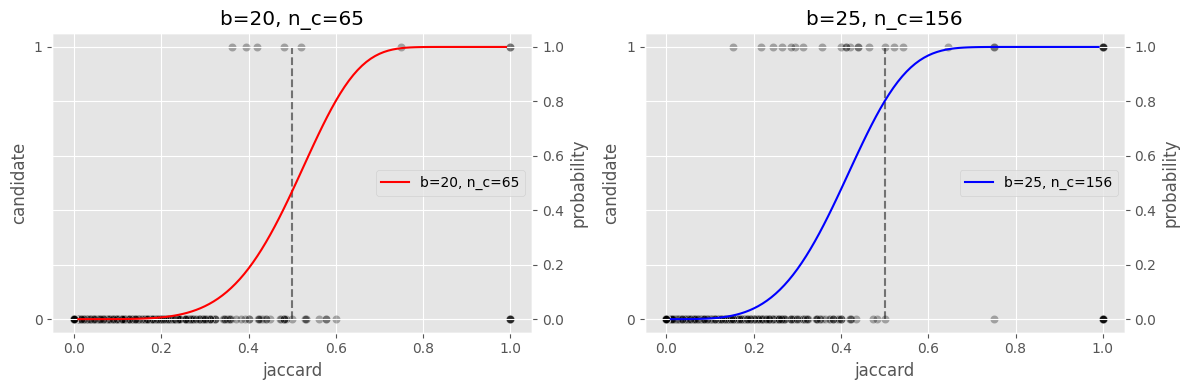

In [136]:
thresholds = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, lsh.r, lsh.b) for s in thresholds]
P_scores2 = [probability(s, lsh2.r, lsh2.b) for s in thresholds]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
ax1, ax2 = axes
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax22.sharey(ax11)

sns.lineplot(x=thresholds, y=P_scores, label=f'b={lsh.b}, n_c={len(candidate_pairs)}', color='r', ax=ax11)
sns.lineplot(x=thresholds, y=P_scores2, label=f'b={lsh2.b}, n_c={len(candidate_pairs2)}', color='b', ax=ax22)
sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.3, color='k', ax=ax1)
sns.scatterplot(data=pairs2, x='jaccard', y='candidate', alpha=0.3, color='k', ax=ax2)
for ax in axes:
    ax.vlines(0.5, 0, 1, color='k', linestyle='--', alpha=0.5, label='threshold=0.5')
ax11.legend(loc='center right')
ax11.set_ylabel('probability')
ax22.legend(loc='center right')
ax22.set_ylabel('probability')
ax1.set_yticks([0, 1])
ax2.set_yticks([0, 1])
ax1.set_title(f'b={lsh.b}, n_c={len(candidate_pairs)}')
ax2.set_title(f'b={lsh2.b}, n_c={len(candidate_pairs2)}')
plt.tight_layout()
plt.show()

# Jaccard

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [ ]:

def jaccard(x: set, y: set):
    shared = x.intersection(y)
    union = x.union(y)
    return len(shared) / len(union)

sentence1 = 'The quick brown fox jumps over the lazy dog'.lower()
sentence2 = 'A fast brown fox leaps over a lazy dog'.lower()
sentence3 = 'The brown cat walks under the busy dog'.lower()

set1 = set(sentence1.split())
set2 = set(sentence2.split())
set3 = set(sentence3.split())


print(f'Jaccard similarity for sentences:\ns1: {sentence1}\ns2: {sentence2}')
print(f'J = {jaccard(set1, set2):.4f}')
print(f'Jaccard similarity for sentences:\ns1: {sentence1}\ns3: {sentence3}')
print(f'J = {jaccard(set1, set3):.4f}')

v = venn3([set1, set2, set3], set_labels=('Sentence 1', 'Sentence 2', 'Sentence3'))

# S = s_1 \cup s_2 \cup s_3
s100 = set1-set2-set3  # S \setminus (s_2 \cup s_3)
s010 = set2-set1-set3  # S \setminus (s_1 \cup s_3)
s001 = set3-set1-set2  # S \setminus (s_1 \cup s_2)
s110 = set1&set2-set3  # (s_1 \cap s_2) \setminus s_3
s101 = set1&set3-set2  # (s_1 \cap s_3) \setminus s_2
s011 = set2&set3-set1  # (s_2 \cap s_3) \setminus s_1
s111 = set1&set2&set3  # s_1 \cap s_2 \cap s_3

for s, s_id in zip([s100, s010, s001, s110, s101, s011, s111], 
                   ['100', '010', '001', '110', '101', '011', '111']):
    v.get_label_by_id(s_id).set_text('\n'.join([str(len(s))]+list(s)))
    v.get_label_by_id(s_id).set_fontsize(9)

plt.show()

# W-Shingling

In [ ]:
def WShingling(s: str, k: int):
    return set([tuple(s[i:i+k]) for i in range(len(s)-k+1)])

k = 2
set1 = WShingling(sentence1.split(), k=k)
set2 = WShingling(sentence2.split(), k=k)
set3 = WShingling(sentence3.split(), k=k)

print(f'W-Shingling similarity for sentences:\ns1: {sentence1}\ns2: {sentence2}')
print(f'W = {jaccard(set1, set2):.4f}')
print(f'W-Shingling similarity for sentences:\ns1: {sentence1}\ns3: {sentence3}')
print(f'W = {jaccard(set1, set3):.4f}')

# Lev